# Human Activity Recognition (HAR) Using Smartphones

Dataset contains Smartphone data of 30 subjects performing one of **6 activities**. <br>
**Multivariate timeseries data**, consisting of acceleromenter and gyroscope values. <br>
The task is **classifying** every timeseries to one of the acivities out of: **Walking**, **Walking-Upstairs**, **Walking-Doenstairs**, **Sitting**, **Standing**, **Laying**.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# custom dataloader to handle the UCI HAR Dataset
from dataloader import UCIHARDataset, make_har_loaders

# Define Baseline CNN Model

In [3]:
class Baseline(nn.Module):
    """
    Simple CNN baseline:
      Conv1d -> ReLU -> MaxPool
      Conv1d -> ReLU -> MaxPool
      Global average pooling
      Linear -> Softmax  
    """
    def __init__(self, in_channels=6, num_classes=6):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 128 -> 64

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 64 -> 32

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.gap = nn.AdaptiveAvgPool1d(1)  # Global average pooling (batch, 128, 32) -> (batch, 128, 1)
        self.calssifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch, in_channels, time)
        x = self.features(x)
        x = self.gap(x).squeeze(-1)  # (batch, 128, 1) -> (batch, 128)
        logits = self.calssifier(x)       # (batch, num_classes)
        return logits

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(29012026)

# initaialize
train_loader, test_loader = make_har_loaders(root="./UCI HAR Dataset", channels="6ch", batch_size=128)
model = Baseline(in_channels=6, num_classes=6).to(DEVICE)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [10]:
epochs = 50
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for x,y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        total_acc += (preds == y).float().mean().item()

    total_loss /= len(train_loader)
    total_acc /= len(train_loader)
    print(f"Epoch {epoch}/{epochs} - Train Loss: {total_loss:.4f}, Train Acc: {total_acc:.4f}")

    # Evaluation
    model.eval()
    with torch.no_grad():
        total_loss, total_acc = 0.0, 0.0

        for x,y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_acc += (preds == y).float().mean().item()

        total_loss /= len(test_loader)
        total_acc /= len(test_loader)
        print(f"Epoch {epoch}/{epochs} - Test Loss: {total_loss:.4f}, Test Acc: {total_acc:.4f}")

# Save the model
torch.save(model.state_dict(), "har_baseline_model.pth")
print("Model saved to har_baseline_model.pth")

Epoch 1/50 - Train Loss: 1.4079, Train Acc: 0.3491
Epoch 1/50 - Test Loss: 1.1324, Test Acc: 0.3574
Epoch 2/50 - Train Loss: 0.8864, Train Acc: 0.5575
Epoch 2/50 - Test Loss: 0.7412, Test Acc: 0.6273
Epoch 3/50 - Train Loss: 0.6773, Train Acc: 0.6202
Epoch 3/50 - Test Loss: 0.6592, Test Acc: 0.6387
Epoch 4/50 - Train Loss: 0.6325, Train Acc: 0.6371
Epoch 4/50 - Test Loss: 0.6565, Test Acc: 0.6370
Epoch 5/50 - Train Loss: 0.6149, Train Acc: 0.6489
Epoch 5/50 - Test Loss: 0.6257, Test Acc: 0.6536
Epoch 6/50 - Train Loss: 0.6003, Train Acc: 0.6537
Epoch 6/50 - Test Loss: 0.6180, Test Acc: 0.6771
Epoch 7/50 - Train Loss: 0.5879, Train Acc: 0.6682
Epoch 7/50 - Test Loss: 0.6179, Test Acc: 0.6852
Epoch 8/50 - Train Loss: 0.5778, Train Acc: 0.6800
Epoch 8/50 - Test Loss: 0.5977, Test Acc: 0.6986
Epoch 9/50 - Train Loss: 0.5670, Train Acc: 0.6891
Epoch 9/50 - Test Loss: 0.6031, Test Acc: 0.6995
Epoch 10/50 - Train Loss: 0.5543, Train Acc: 0.7021
Epoch 10/50 - Test Loss: 0.6081, Test Acc: 0.717

Test Acc after 50 epochs: 0.9020

# Hypothesis 1:
Different physical measurements, so use different CNNs as inputs to process individually and fuse later.

In [15]:
class LateFusionHAR(nn.Module):
    """
    Late Fusion CNN for HAR:
      Separate Conv1d branches for each sensor channel
      Concatenate features
      Global average pooling
      Linear -> Softmax  
    """
    def __init__(self, n_classes: int = 6, base: int = 32, dropout: float=0.2):
        super().__init__()
        self.accelerometer_branch = nn.Sequential(
            nn.Conv1d(3, base, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 128 -> 64

            nn.Conv1d(base, base*2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 64 -> 32

            nn.Conv1d(base*2, base*4, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.acc_gap = nn.AdaptiveAvgPool1d(1)

        self.gyroscope_branch = nn.Sequential(
            nn.Conv1d(3, base, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 128 -> 64   

            nn.Conv1d(base, base*2, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 64 -> 32

            nn.Conv1d(base*2, base*4, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.gyro_gap = nn.AdaptiveAvgPool1d(1)

        fused_dimension = (base * 4) * 2  # because of concatenation
        self.classifier = nn.Sequential(
            nn.Linear(fused_dimension, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        acc_input = x[:, :3, :]  # First 3 channels are accelerometer
        gyro_input = x[:, 3:6, :]  # Last 3 channels are gyroscope

        f_acc = self.accelerometer_branch(acc_input)
        f_acc = self.acc_gap(f_acc).squeeze(-1)  # (batch, base*4, 1) -> (batch, base*4)

        f_gyro = self.gyroscope_branch(gyro_input)
        f_gyro = self.gyro_gap(f_gyro).squeeze(-1)  # (batch, base*4, 1) -> (batch, base*4)

        f_fused = torch.cat((f_acc, f_gyro), dim=1)  # (batch, base*8)
        logits = self.classifier(f_fused)  # (batch, n_classes)
        return logits


# Hypothesis 2:
Use different kernel sizes in parallel to capture temporal dependencies in short, mid and long time windows

In [18]:
class MulitiScaleBlock(nn.Module):
    """
    Multi-Scale Conv1d Block:
      Parallel Conv1d layers with different kernel sizes
      Concatenate features
    """
    def __init__(self, in_channels: int, out_channels_per_branch: int = 32, kernel_sizes=[3, 7, 15]):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(in_channels, out_channels_per_branch, kernel_size=k, padding=k//2),
                nn.ReLU()
            )
            for k in kernel_sizes
        ])

    def forward(self, x):
        outs = [b(x) for b in self.branches]
        return torch.cat(outs, dim=1)  # Concatenate along channel dimension
    

class MultiScaleHAR(nn.Module):
    """
    Multi-Scale CNN for HAR:
      Multiple Conv1d branches with different kernel sizes
      Concatenate features
      Global average pooling
      Linear -> Softmax  
    """
    def __init__(self, n_classes: int = 6, dropout: float=0.2):
        super().__init__()
        
        self.ms1 = MulitiScaleBlock(in_channels=6, out_channels_per_branch=32, kernel_sizes=[3, 7, 15])
        c1 = 32 * 3

        self.pool1 = nn.MaxPool1d(kernel_size=2)  # 128 -> 64

        self.conv2 = nn.Sequential(
            nn.Conv1d(c1, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2), # 64 -> 32
            nn.Conv1d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.ms1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.gap(x).squeeze(-1)
        logits = self.classifier(x)
        return logits


# Test all three models

In [19]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(29012026)

# initaialize
train_loader, test_loader = make_har_loaders(root="./UCI HAR Dataset", channels="6ch", batch_size=128)
baseline = Baseline(in_channels=6, num_classes=6).to(DEVICE)
optimizer_baseline = Adam(baseline.parameters(), lr=1e-3)

late_fusion = LateFusionHAR(n_classes=6, base=32, dropout=0.2).to(DEVICE)
optimizer_late = Adam(late_fusion.parameters(), lr=1e-3)

muliscale = MultiScaleHAR(n_classes=6, dropout=0.2).to(DEVICE)
optimizer_multi = Adam(muliscale.parameters(), lr=1e-3)

criterion = nn.CrossEntropyLoss()

In [21]:
epochs = 50
test_accs = []
for model, optimizer in [(baseline, optimizer_baseline), (late_fusion, optimizer_late), (muliscale, optimizer_multi)]:
    test_acc = []
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total_loss, total_acc = 0.0, 0.0
    
        for x,y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
    
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_acc += (preds == y).float().mean().item()
    
        total_loss /= len(train_loader)
        total_acc /= len(train_loader)
        print(f"[{model.__class__.__name__}] Epoch {epoch}/{epochs} - Train Loss: {total_loss:.4f}, Train Acc: {total_acc:.4f}")
    
        # Evaluation
        model.eval()
        with torch.no_grad():
            total_loss, total_acc = 0.0, 0.0
    
            for x,y in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
    
                logits = model(x)
                loss = criterion(logits, y)
    
                total_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                total_acc += (preds == y).float().mean().item()
    
            total_loss /= len(test_loader)
            total_acc /= len(test_loader)
            print(f"[{model.__class__.__name__}] Epoch {epoch}/{epochs} - Test Loss: {total_loss:.4f}, Test Acc: {total_acc:.4f}")
            test_acc.append(total_acc)
    
    # Save the model
    torch.save(model.state_dict(), f"har_{model.__class__.__name__.lower()}_model.pth")
    print(f"Model saved to har_{model.__class__.__name__.lower()}_model.pth")
    test_accs.append(test_acc)

[Baseline] Epoch 1/50 - Train Loss: 1.3957, Train Acc: 0.3567
[Baseline] Epoch 1/50 - Test Loss: 1.0693, Test Acc: 0.4339
[Baseline] Epoch 2/50 - Train Loss: 0.8511, Train Acc: 0.5591
[Baseline] Epoch 2/50 - Test Loss: 0.7284, Test Acc: 0.6348
[Baseline] Epoch 3/50 - Train Loss: 0.6684, Train Acc: 0.6177
[Baseline] Epoch 3/50 - Test Loss: 0.6500, Test Acc: 0.6380
[Baseline] Epoch 4/50 - Train Loss: 0.6267, Train Acc: 0.6376
[Baseline] Epoch 4/50 - Test Loss: 0.6393, Test Acc: 0.6305
[Baseline] Epoch 5/50 - Train Loss: 0.6131, Train Acc: 0.6436
[Baseline] Epoch 5/50 - Test Loss: 0.6478, Test Acc: 0.6292
[Baseline] Epoch 6/50 - Train Loss: 0.5971, Train Acc: 0.6597
[Baseline] Epoch 6/50 - Test Loss: 0.6386, Test Acc: 0.6650
[Baseline] Epoch 7/50 - Train Loss: 0.5845, Train Acc: 0.6681
[Baseline] Epoch 7/50 - Test Loss: 0.6498, Test Acc: 0.6585
[Baseline] Epoch 8/50 - Train Loss: 0.5722, Train Acc: 0.6791
[Baseline] Epoch 8/50 - Test Loss: 0.6319, Test Acc: 0.6641
[Baseline] Epoch 9/50 - 

# Plot all accuracies

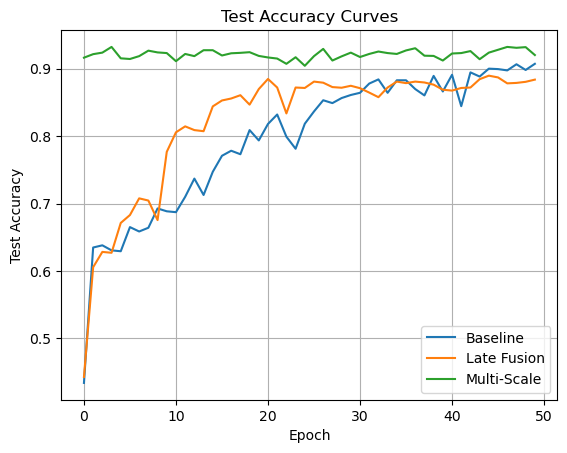

In [22]:
import matplotlib.pyplot as plt

labels = ["Baseline", "Late Fusion", "Multi-Scale"]

for acc, label in zip(test_accs, labels):
    plt.plot(acc, label=label)

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()